# Analysis notebook - Optimization of Home Improvements for Satisfaction and Maternal Mental Health

In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

# Intro

In this section some visualization are produced to familiarize the public with the dataset.

### Loading the data

In [2]:
# Load the data

df = pd.read_stata('data/PisoFirme_AEJPol-20070024_household.dta')
df.head()

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,...,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
0,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,14.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.903487
1,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,17.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.615806
2,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,16.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,6.214608,10.819778
3,0.0,70000537.0,-103.50367,25.583067,7.0,47,0.3,0.036629,0.555554,819.0,...,20.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,11.385092,11.918390
4,0.0,70000537.0,-103.50367,25.583067,7.0,47,0.3,0.036629,0.555554,819.0,...,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.703783,10.819778


In [3]:
# Replace missing values by 0
household = df.fillna(0,inplace=False)

# Aggregate variables by census block
df_census = household[['idcluster','dpisofirme','coord_x','coord_y','C_HHdirtfloor','C_households','C_poverty','S_cementfloor2000','S_shcementfloor']]
df_census = df_census.drop(index = df_census.loc[df_census['idcluster'] == 0].index)
df_cluster = df_census.groupby(df_census.idcluster).mean()
household = df_cluster[df_cluster.coord_x !=0]
household

,dpisofirme,coord_x,coord_y,C_HHdirtfloor,C_households,C_poverty,S_cementfloor2000,S_shcementfloor
idcluster,,,,,,,,
70000537.0,0.0,-103.503670,25.583067,0.036629,819.0,0.062267,0.700000,0.728571
70000679.0,0.0,-103.489845,25.578873,0.030579,327.0,0.079503,0.319048,0.835714
70000683.0,0.0,-103.486130,25.579157,0.100773,364.0,0.098901,0.750000,1.000000
70000772.0,0.0,-103.486664,25.572720,0.012791,391.0,0.030698,0.833333,1.000000
70000787.0,0.0,-103.482887,25.574093,0.136489,475.0,0.145260,0.436172,0.801557
...,...,...,...,...,...,...,...,...
352580000.0,1.0,-103.421715,25.575386,0.094060,591.0,0.093069,0.288739,0.979730
352650000.0,1.0,-103.400169,25.542471,0.027318,1064.0,0.040416,0.440000,0.880000
353080000.0,1.0,-103.418747,25.584503,0.274927,237.0,0.177212,0.163793,0.858621


In [4]:
idcluster = household.index

# Create column state
household['state'] = 0
for i in range(len(household)):
    n = idcluster[i]
    if household['dpisofirme'][n] == 1:
        household['state'][n] = 'Coahuila'
    else:
        household['state'][n] = 'Durango'

# create a "color_dirtfloor" column to split the clusters into different groups 
# according to their dirt floor proportion level
household['color_dirtfloor'] = 0
for i in range(len(household)):
    n = idcluster[i]
    if household['C_HHdirtfloor'][n] < 0.05:
        household['color_dirtfloor'][n] = "< 0.05"
    elif household['C_HHdirtfloor'][n] < 0.15:
        household['color_dirtfloor'][n] = "0.05-0.15"
    else:
        household['color_dirtfloor'][n] = "> 0.15"
        
# create a "color_poverty" column to split the clusters into different groups 
# according to their poverty proportion level
household['color_poverty'] = 0
for i in range(len(household)):
    n = idcluster[i]
    if household['C_poverty'][n] < 0.05:
        household['color_poverty'][n] = "< 0.05"
    elif household['C_poverty'][n] < 0.15:
        household['color_poverty'][n] = "0.05-0.15"
    else:
        household['color_poverty'][n] = "> 0.15"

In [96]:
# Plot on the map distribution of households
px.set_mapbox_access_token("pk.eyJ1Ijoic3VqaW5ncmFuMDYyNSIsImEiOiJja2lucHhxeHAwcXo2MnhxczZoZGV0c2E4In0.CVZgEUpwtli5MDHsYIwUQg")
fig = px.scatter_mapbox(household, lat="coord_y", lon="coord_x", color="state",
                          color_discrete_sequence=["red", "blue"],zoom=10.5)
fig.update_layout(
        mapbox = {
        'style': "outdoors"},
        title_text = 'Distribution of census block in Coahuila and Durango<br>',
        showlegend = True)

fig.show()

# Save plot in html file
fig.write_html('figures/cluster_map.html')

In [6]:
# Plot on the map proportion of households with dirtfloors by clusters
px.set_mapbox_access_token("pk.eyJ1Ijoic3VqaW5ncmFuMDYyNSIsImEiOiJja2lucHhxeHAwcXo2MnhxczZoZGV0c2E4In0.CVZgEUpwtli5MDHsYIwUQg")
fig = px.scatter_mapbox(household, lat="coord_y", lon="coord_x", size="C_households",
                        color="color_dirtfloor",
                        color_discrete_sequence=["lightseagreen", "gold", "crimson"],
                        size_max=12, zoom=10.5, labels={'color_dirtfloor':'Proportion of households with dirtfloors',
                                                       'C_households':'Number of households'})
fig.update_layout(
         mapbox = {
        'style': "basic"},
        title_text = '2000 Distribution of census block with proportion of dirt cement floors<br>',
        showlegend = True)

fig.show()

# Save plot in html file
fig.write_html('figures/dirtfloor_map.html')

In [7]:
# Plot on the map proportion of households below the poverty line by clusters
px.set_mapbox_access_token("pk.eyJ1Ijoic3VqaW5ncmFuMDYyNSIsImEiOiJja2lucHhxeHAwcXo2MnhxczZoZGV0c2E4In0.CVZgEUpwtli5MDHsYIwUQg")
fig = px.scatter_mapbox(household, lat="coord_y", lon="coord_x", size="C_households",
                        color="color_poverty",
                        color_discrete_map={"< 0.05":"cornflowerblue", 
                                                 "0.05-0.15":"orange",
                                                 "> 0.15":"red"},
                        size_max=12, zoom=10.5, labels={'color_poverty':'Proportion of households below poverty line',
                                                       'C_households':'Number of households'})
fig.update_layout(
         mapbox = {
        'style': "basic"},
        title_text = '2000 Distribution of census block with proportion of households below poverty line<br>',
        showlegend = True)

fig.show()

# Save plot in html file
fig.write_html('figures/poverty_map.html')

In [8]:
# Compute some statistics (total number of households, number of households with dirtfloors
# and number of households below poverty line)

total_households = household.C_households.sum()
nb_dirtfloors = round((household.C_HHdirtfloor * household.C_households).sum())
nb_poverty = round((household.C_poverty * household.C_households).sum())
nb_poverty

5293

In [9]:
# Compute proportion of households with and without dirtfloors in a dataframe

stats_dirtfloors = pd.DataFrame([[total_households - nb_dirtfloors,
                     nb_dirtfloors]],
                     columns=['Households without dirtfloors', 'Households with dirtfloors']).transpose().reset_index().rename(columns={0: "value"})
stats_dirtfloors

,index,value
0,Households without dirtfloors,50604.0
1,Households with dirtfloors,5653.0


In [10]:
# Compute proportion of households above and below poverty line

stats_poverty = pd.DataFrame([[total_households - nb_poverty, 
                     nb_poverty]],
                     columns=['Households above the poverty line', 'Households below the poverty line']).transpose().reset_index().rename(columns={0: "value"})
stats_poverty

,index,value
0,Households above the poverty line,50964.0
1,Households below the poverty line,5293.0


In [11]:
# Plot pie charts
fig = px.pie(stats_dirtfloors, values='value', names='index')
fig.show

# Save plot in html file
fig.write_html('figures/dirtfloor_pie.html')

In [12]:
fig = px.pie(stats_poverty, values='value', names='index')
fig.show()

# Save plot in html file
fig.write_html('figures/poverty_pie.html')

# Research question 1

## Are adults happier when they invest in installation of cement floors ?

Why doesn't the government create campaigns to promote installation of cement floors in households ? This could be a very cost-effective action to improve general well-being in the region of interest. But if we want to advise households on what improvement they should invest in, we need to make sure that households who invested by themselves in cement floors received similar benefits as households who were proposed Piso Firme. Therefore we will verify that households that decided to install cement floors without aid from the government also show the same benefits.

In [13]:
# Define the group durango (the control group of the original paper)
durango = df[df.dpisofirme == 0]

Now we will define the control and treatment group for our experiment. We consider only households which were not proposed Piso Firme (durango). The new treatment group will be households which installed cement floors (S_instcement = 1) by themselve, the new control group will be people who did not install cement floors (S_instcement = 0).

<AxesSubplot:>

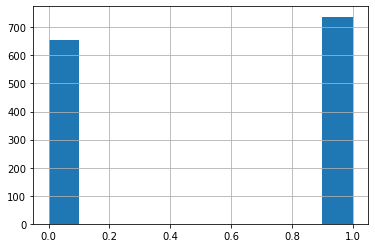

In [14]:
# Plot
durango.S_instcement.hist()

We can see that the two groups are balanced.

## Matching

### Propensity scores computation

In [15]:
durango = durango.dropna(subset=['S_instcement', 'S_incomepc'])

In [16]:
# Build the model

mod = smf.logit(formula='S_instcement ~  S_incomepc', data=durango)

res = mod.fit()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.690999
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           S_instcement   No. Observations:                 1390
Model:                          Logit   Df Residuals:                     1388
Method:                           MLE   Df Model:                            1
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:               0.0004649
Time:                        17:57:16   Log-Likelihood:                -960.49
converged:                       True   LL-Null:                       -960.93
Covariance Type:            nonrobust   LLR p-value:                    0.3445
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1069      0.056      1.905      0.057      -0.003       0.217
S_incomepc  1.376e-05   1.65e

In [17]:
# Compute the propensity scores

durango['propensity_score'] = res.predict()

In [18]:
# Define control and treatment groups
treatment = durango[durango.S_instcement == 1]
control = durango[durango.S_instcement == 0]

In [19]:
# Function to compute similarity from two propensity scores
def get_similarity(ps1, ps2):
    return 1-np.abs(ps1 - ps2)

In [20]:
# Matching step using our computed propensity scores

# Create an undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for treatment_id, treatment_row in treatment.iterrows():
    for control_id, control_row in control.iterrows():
        
        # Calculate the similarity 
        similarity = get_similarity(control_row['propensity_score'],
                                     treatment_row['propensity_score'])
        
        # take epsilon = 0.05 as a threshold for matching
        if similarity > 0.95:
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [21]:
# put the balanced pairs of papers into one dataframe
match_0 = durango.loc[pd.DataFrame(matching)[0]]
match_1 = durango.loc[pd.DataFrame(matching)[1]]
durango_match = pd.concat([match_0,match_1])

# report the number of pairs
print("The number of matched pairs is {}, and the number of unmatched ones is {}.".format(len(match_0),\
                                                                                     len(treatment)-len(match_0)))

The number of matched pairs is 653, and the number of unmatched ones is 84.


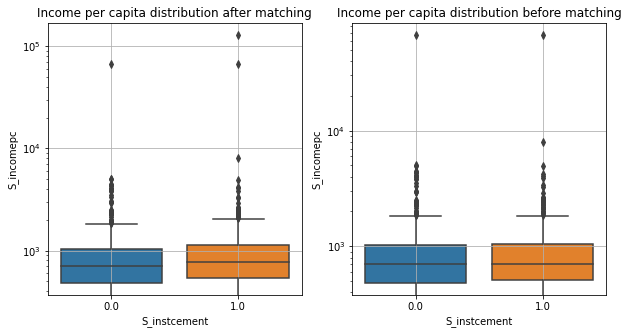

In [22]:
# display the plots before and after matching
fig = plt.subplots(1,2,figsize= (10,5))

# after matching
plt.subplot(1,2,1)
ax = sns.boxplot(x="S_instcement", y="S_incomepc", data=durango)
ax.set_title('Income per capita distribution after matching')
ax.set(yscale="log")
ax.grid(True)

# before matching
plt.subplot(1,2,2)
ax = sns.boxplot(x="S_instcement", y="S_incomepc", data=durango_match)
ax.set_title('Income per capita distribution before matching')
ax.set(yscale="log")
ax.grid(True)

In [23]:
durango_mean_income = durango.groupby('S_instcement').agg('mean').reset_index()[['S_incomepc']]

fig = go.Figure(data=[
    go.Bar(name='Did not install cement floors', y=durango_mean_income.loc[0], width=[0.1]),
    go.Bar(name='Installed cement floors', y=durango_mean_income.loc[1], width=[0.1])
])

fig.update_layout(
        title_text = 'Mean household income per capita before matching',
        showlegend = True)
fig.update_layout(barmode='group')
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(title_text='Mean household income per capita')
fig.show()

# Save plot in html file
fig.write_html('figures/income_before_matching.html')

In [24]:
durango_match_mean_income = durango_match.groupby('S_instcement').agg('mean').reset_index()[['S_incomepc']]

fig = go.Figure(data=[
    go.Bar(name='Did not install cement floors', y=durango_match_mean_income.loc[0], width=[0.1]),
    go.Bar(name='Installed cement floors', y=durango_match_mean_income.loc[1], width=[0.1])
])

fig.update_layout(
        title_text = 'Mean household income per capita after matching',
        showlegend = True)
fig.update_layout(barmode='group')
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(title_text='Mean household income per capita')
fig.show()

# Save plot in html file
fig.write_html('figures/income_after_matching.html')

The matching seems successful.

### Data cleaning

In [25]:
# Define the group durango (the control group of the original paper)
df_rq1 = durango_match[durango_match.dpisofirme == 0]

df_rq1 = df_rq1.fillna(0,inplace=False)

# A lot of entries are missing for the variable spouseeduc, we replace them by the value 0
df_rq1.S_spouseeduc = df_rq1.S_spouseeduc.fillna(0)

# Define all variables that will be used in the analysis

variables = ['idcluster', # cluster indicator
             'S_instcement', # sntallation of cement
             'S_satisfloor','S_satishouse','S_satislife','S_cesds','S_pss', # happiness/satisfaction variables
             'S_cementfloorkit','S_cementfloordin','S_cementfloorbat','S_cementfloorbed', # presence of cement in rooms
             'S_HHpeople','S_headage','S_spouseage','S_headeduc', # control variables (demographic, health, social)
             'S_spouseeduc','S_dem1','S_dem2','S_dem3','S_dem4','S_dem5','S_dem6',
             'S_dem7','S_dem8','S_waterland','S_waterhouse','S_electricity','S_hasanimals',
             'S_animalsinside','S_garbage','S_washhands','S_cashtransfers','S_milkprogram',
             'S_foodprogram','S_seguropopular']

# Drop samples with missing values in defined variables
df_rq1 = df_rq1.dropna(subset=variables)



### Regression

In [67]:
# Define control and treatment dataframes
control_df_rq1 = df_rq1[df_rq1.S_instcement == 0]
treatment_df_rq1 = df_rq1[df_rq1.S_instcement == 1]

# Define the regression model for our analysis including demographic, health and social control variables

def regression(dependent, dataframe):
    """
    Performs a regression using the defined model on the dependent variable in parameters
    using the given dataframe.
    Returns coeff, std and p-value of the result-
    """
    mod = smf.ols(formula= dependent + ' ~ C(S_instcement) + \
          S_HHpeople + S_headage + S_spouseage + S_headeduc + S_spouseeduc + \
          S_dem1 + S_dem2 + S_dem3 + S_dem4 + S_dem5 + S_dem6 + S_dem7 + S_dem8 + \
          C(S_waterland) + C(S_waterhouse) + C(S_electricity) + C(S_hasanimals) + C(S_animalsinside) + \
          C(S_garbage) + S_washhands + \
          S_cashtransfers + C(S_milkprogram) + C(S_foodprogram) + C(S_seguropopular)', data=dataframe)
    res = mod.fit(cov_type='cluster',cov_kwds={'groups':dataframe['idcluster']})  
    return res.params[1],res.bse[1],res.pvalues[1]

# Define dependent variables of interest
happiness = ['S_satisfloor','S_satishouse','S_satislife','S_cesds','S_pss']


# Define table to print result
result_table = pd.DataFrame(columns = ['Dependent variable', 'Control mean', 'coeff', 'std', 'p-value', 'effect'])

# Run regression for every dependent variable and show table
for i, v in enumerate(happiness):
    
    
    control_mean = control_df_rq1[v].mean()
    coeff, std, pval = regression(v, df_rq1)
    
    result_table.loc[i] = [v, control_mean, coeff, std, round(pval, 3), 100*coeff/control_mean]
    
result_table = result_table.set_index("Dependent variable")
result_table

,Control mean,coeff,std,p-value,effect
Dependent variable,,,,,
S_satisfloor,0.477795,0.052826,0.029185,0.070,11.056192
S_satishouse,0.595712,0.007420,0.028514,0.795,1.245552
S_satislife,0.577335,0.019131,0.030111,0.525,3.313720
S_cesds,18.560490,0.384050,0.811667,0.636,2.069181
S_pss,16.189894,0.776537,0.756354,0.305,4.796431


In [75]:
# Create a significance column (boolean)
result_table['significant'] = result_table['p-value'] < 0.1

# Create a column to store color that will be used to plot
result_table['color'] = ''

# Significant results get color darkcyan, non-significant results are grey
for i in range(len(result_table)):
    if result_table['significant'][i]:
        result_table['color'][i] = 'darkcyan'
    else:
        result_table['color'][i] = '#808080'
    
result_table

,Control mean,coeff,std,p-value,effect,significant,color
Dependent variable,,,,,,,
S_satisfloor,0.477795,0.052826,0.029185,0.070,11.056192,True,darkcyan
S_satishouse,0.595712,0.007420,0.028514,0.795,1.245552,False,#808080
S_satislife,0.577335,0.019131,0.030111,0.525,3.313720,False,#808080
S_cesds,18.560490,0.384050,0.811667,0.636,2.069181,False,#808080
S_pss,16.189894,0.776537,0.756354,0.305,4.796431,False,#808080


In [95]:
# Plot the effect
fig = px.bar(result_table, x=['Satisfaction with floor quality',
                              'Satisfaction with house quality',
                              'Satisfaction with quality of life',
                              'Depression Scale (CES-D Scale)',
                              'Perceived Stress Scale (PSS)'], y='effect',
             color='significant',
             color_discrete_sequence=['lightseagreen', 'lightgrey'],
             labels={'S_satisfloor':'Satisfaction with floor quality',
                   'S_satishouse':'Satisfaction with house quality',
                   'S_satislife':'Satisfaction with quality of life',
                   'S_cesds':'Depression Scale (CES-D Scale)',
                   'S_pss':'Perceived Stress Scale (PSS)',
                   'effect':'Effect (in %)'},
            title='Effect of investment in cement floors on mental health variables')


fig.update_xaxes(title='Mental health variables', visible=True, showticklabels=True)
fig.show()

# Save plot in html file
fig.write_html('figures/poverty_map.html')

### Conclusion of research question 1

We can conclude that installation of cement floor does improve floor satisfaction of about 11% (10% significance level), but there is no strong evidence saying it increases the house and life satisfaction significantly in other variables. More research would need to be done on this side. Also the stress level doesn't seem to get lower, maybe because households need to spend a part of their revenue for it, creating potential economic concerns in those households. To increase happiness, advising households to invest in cement floors is not sufficient, governmental programs such as Piso Firme seem to be necessary for the well-being of these households.

# Research question 2

## What housing improvements have the greatest effect on the mental health and well-being of the house caretaker? 

In [119]:
# Reload dataframe
df = pd.read_stata('data/PisoFirme_AEJPol-20070024_household.dta').fillna(0)
df

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,...,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
0,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,14.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.903487
1,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,17.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.615806
2,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,16.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,6.214608,10.819778
3,0.0,70000537.0,-103.50367,25.583067,7.0,47,0.3,0.036629,0.555554,819.0,...,20.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,11.385092,11.918390
4,0.0,70000537.0,-103.50367,25.583067,7.0,47,0.3,0.036629,0.555554,819.0,...,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.703783,10.819778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778,1.0,0.0,0.00000,0.000000,35.0,999,0.0,0.000000,0.000000,0.0,...,27.0,31.0,1.0,0.0,0.0,0.0,1.0,1.0,6.684612,10.819778
2779,1.0,0.0,0.00000,0.000000,35.0,999,0.0,0.000000,0.000000,0.0,...,32.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,5.703783,9.615806
2780,1.0,0.0,0.00000,0.000000,35.0,999,0.0,0.000000,0.000000,0.0,...,28.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.903487
2781,1.0,0.0,0.00000,0.000000,35.0,999,0.0,0.000000,0.000000,0.0,...,22.0,22.0,1.0,0.0,0.0,0.0,1.0,1.0,6.551080,11.512925


In [120]:
# Define control
control = df[df.S_instcement == 0]

# Define parameters for regressions
parameters = ['S_satisfloor', 'S_satishouse', 'S_satislife', 'S_cesds', 'S_pss']

In [121]:
# Create blank list to store results
stats = []

# Loop through all parameters to get mean and standard deviation
for parameter in parameters:
    stats.append([control[parameter].mean(), control[parameter].std()])

# Make DataFrame
stats = pd.DataFrame(stats, columns = ['control_mean', 'control_std']).set_index(pd.Index(parameters))

# Print 
stats

,control_mean,control_std
S_satisfloor,0.507006,0.500270
S_satishouse,0.610191,0.488018
S_satislife,0.593631,0.491468
S_cesds,18.100637,9.462132
S_pss,15.825478,7.208899


### Build the models

We are interested in the different impacts that different rooms on the house with cement floors have on the happiness and mental health from the cartaker of the house. We analyze the main bedroom, kitchen, dining room, and bathroom.

We also perform a correction in each model to make sure the effects from other control variables do not change the results.

In [122]:
# Create models
model1 = ' ~ C(S_cementfloorbed)'

model2 = ' ~ C(S_cementfloorkit)'

model3 = ' ~ C(S_cementfloordin)'

model4 = ' ~ C(S_cementfloorbat)'

# Create correction
correction = '+ S_HHpeople + S_headage + S_spouseage + S_headeduc + S_spouseeduc + S_rooms + \
S_dem1 + S_dem2 + S_dem3 + S_dem4 + S_dem5 + S_dem6 + S_dem7 + S_dem8 + C(S_hasanimals) +\
C(S_animalsinside) + C(S_waterhouse) + C(S_waterland) + C(S_electricity) + S_washhands + C(S_garbage)\
+ S_cashtransfers + C(S_milkprogram) + C(S_foodprogram) + C(S_seguropopular)'

# Create a list in which all the models are included
models = [model1, model2, model3, model4]

# Create an index to keep track of the name of the model
model_idx = ['Bedroom', 'Kitchen', 'Dining', 'Bathroom']

# We print the model list just for visuals
models

[' ~ C(S_cementfloorbed)',
 ' ~ C(S_cementfloorkit)',
 ' ~ C(S_cementfloordin)',
 ' ~ C(S_cementfloorbat)']

### Performing the assessment

We now procceed to assess the impact of the different models. We utilize least squares regression capturing data for the coefficients, standard deviation, effect of the variable over the control group, and we categorized the significance according to the p-value in the following categories: less than 1% [\*\*\*], less than 5% [\*\*], less than 10% [\*], and other [].

In [123]:
for i, model in enumerate(model_idx):

    # Empty variables to store results
    coef = [] # Coefficients
    perc = [] # Percentages: coefficient/control mean
    std = []  # Stantard deviation: clustered standard error
    pval = [] # P values to determine significance



    # Loop through every parameter and get the fit for each. Store results
    for parameter in parameters:
        mod = smf.ols(formula = parameter + models[i] + correction , data=df)
        res = mod.fit(cov_type = 'cluster', cov_kwds={'groups': df['C_blocksdirtfloor']})

        # Store results
        coef.append(round(list(res.params.values)[1], 4))
        std.append(list(res.bse.values)[1])
        perc.append(round(100*list(res.params.values)[1]/stats['control_mean'].loc[parameter], 4))
        
        # See if the pvalue is significantly different from 0 at 1%, 5% and 10% respectively
        if list(res.pvalues.values)[1] < .01:
            star = '***'
        elif (list(res.pvalues.values)[1] >= .01) & (list(res.pvalues.values)[1] < .05):
            star = '**'
        elif (list(res.pvalues.values)[1] >= .05) & (list(res.pvalues.values)[1] < .1):
            star = '*'
        else:
            star = ''
        
        # Store the mark
        pval.append(star)

    # Store in the control DataFrame
    stats[model + '_coef'] = coef
    stats[model + '_cse'] = std
    stats[model + '_rate'] = perc
    stats[model + '_pval'] = pval

# Print final dataframe
stats

,control_mean,control_std,Bedroom_coef,Bedroom_cse,Bedroom_rate,Bedroom_pval,Kitchen_coef,Kitchen_cse,Kitchen_rate,Kitchen_pval,Dining_coef,Dining_cse,Dining_rate,Dining_pval,Bathroom_coef,Bathroom_cse,Bathroom_rate,Bathroom_pval
S_satisfloor,0.507006,0.500270,0.3246,0.024652,64.0156,***,0.3477,0.028070,68.5724,***,0.3917,0.025724,77.2495,***,0.2529,0.029785,49.8844,***
S_satishouse,0.610191,0.488018,0.1524,0.024982,24.9800,***,0.1615,0.025797,26.4744,***,0.2006,0.026028,32.8815,***,0.1422,0.025227,23.3025,***
S_satislife,0.593631,0.491468,0.2242,0.021560,37.7698,***,0.1941,0.022490,32.6928,***,0.2274,0.025009,38.3025,***,0.1866,0.030411,31.4420,***
S_cesds,18.100637,9.462132,-2.2334,0.480039,-12.3389,***,-2.5254,0.482862,-13.9522,***,-2.9647,0.499591,-16.3790,***,-1.5676,0.586449,-8.6602,***
S_pss,15.825478,7.208899,-1.1026,0.347327,-6.9675,***,-1.4855,0.379172,-9.3866,***,-1.1927,0.423302,-7.5365,***,-0.1454,0.454180,-0.9185,


### Playing wih visualizations

We chose different schemes to visualize the data. Not all of them are gonna be used in the data story.

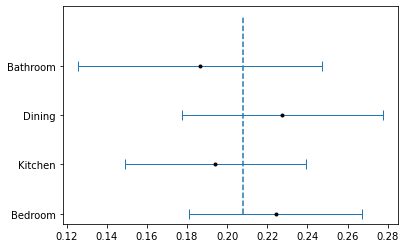

In [124]:
# Example of error bars for Dining room

# Create empty lists to store results
coef = []
std = []

# Get results from main dataset
for model in model_idx:
        coef.append(stats.iloc[2,:][model + '_coef'])
        std.append(stats.iloc[2,:][model + '_cse'])

# Plot error bar
plt.errorbar(coef, np.array(range(len(coef))), xerr= 2*np.array(std), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(np.mean(coef),0, len(coef), linestyle = '--')

plt.yticks(range(len(coef)),model_idx);

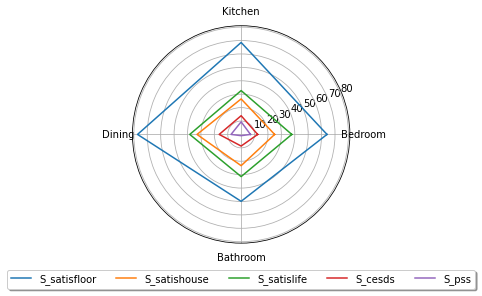

In [125]:
# Example of spider diagram

# Import pi
from math import pi

# Categories
cat = model_idx

# Loop thorugh all the parameters
for i, parameter in enumerate(parameters):
    
    # Lists to store results
    perc = []
    coef = []
    
    # Loop thorugh the different models
    for model in model_idx:
        
        # Store the data
        coef.append(stats.iloc[i,:][model + '_coef'])
        perc.append(abs(stats.iloc[i,:][model + '_rate']))
        
    # Define plot values
    values = perc
    
    # Get angles and close de circle
    N = len(values)
    values += values[:1]
    angles = [n/float(N)*2*(pi) for n in range(N)]
    angles += angles[:1]
    
    # Polar plot
    plt.polar(angles, values, label = parameter)
    

plt.xticks(angles[:-1], cat)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

In [126]:
# Create transposed dataframe
stats_trans = stats.transpose()
# Print
stats_trans

,S_satisfloor,S_satishouse,S_satislife,S_cesds,S_pss
control_mean,0.507006,0.610191,0.593631,18.1006,15.8255
control_std,0.50027,0.488018,0.491468,9.46213,7.2089
Bedroom_coef,0.3246,0.1524,0.2242,-2.2334,-1.1026
Bedroom_cse,0.0246521,0.0249821,0.0215602,0.480039,0.347327
Bedroom_rate,64.0156,24.98,37.7698,-12.3389,-6.9675
Bedroom_pval,***,***,***,***,***
Kitchen_coef,0.3477,0.1615,0.1941,-2.5254,-1.4855
Kitchen_cse,0.0280699,0.0257971,0.02249,0.482862,0.379172
Kitchen_rate,68.5724,26.4744,32.6928,-13.9522,-9.3866
Kitchen_pval,***,***,***,***,***


In [127]:
# Barplot for coefficients

import plotly.graph_objects as go

mask = ['coef' in n for n in list(stats_trans.index)]

fig = go.Figure(data=[
    go.Bar(name= 'Satisfaction with floor', x=model_idx, y=stats_trans.iloc[mask, 0]),
    go.Bar(name= 'Satisfaction with house', x=model_idx, y=stats_trans.iloc[mask, 1]),
    go.Bar(name= 'Satisfaction with life', x=model_idx, y=stats_trans.iloc[mask, 2]),
    go.Bar(name= 'Depression scale', x=model_idx, y=stats_trans.iloc[mask, 3]),
    go.Bar(name= 'Percieved stress', x=model_idx, y=stats_trans.iloc[mask, 4]),
])

# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

# Save plot in html file
fig.write_html('figures/rq2_results_coeff_bar.html')

In [128]:
# Barplot for effect

mask = ['rate' in n for n in list(stats_trans.index)]

fig = go.Figure(data=[
    go.Bar(name= 'Satisfaction with floor', x=model_idx, y=stats_trans.iloc[mask, 0]),
    go.Bar(name= 'Satisfaction with house', x=model_idx, y=stats_trans.iloc[mask, 1]),
    go.Bar(name= 'Satisfaction with life', x=model_idx, y=stats_trans.iloc[mask, 2]),
    go.Bar(name= 'Depression scale', x=model_idx, y=stats_trans.iloc[mask, 3]),
    go.Bar(name= 'Percieved stress', x=model_idx, y=stats_trans.iloc[mask, 4]),
])

# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

# Save plot in html file
fig.write_html('figures/rq2_results_effect_bar.html')

In [131]:
# visualization of cement floor (annotated heatmap)

# Create names for the axis ticks
names = ['Satisfaction with floor', 'Satisfaction with house', 'Satisfaction with life', 'Depression scale', 'Percieved stress']

# Choose color scale
color = 'Balance'

# Import heatmap
import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(np.transpose(stats_trans[mask].values), x=model_idx, y=names, colorscale = color)
fig.update_layout(
        title_text = 'Effect (%) of the presence of cement floor in different rooms on <br>satisfaction and stress indicators with control as baseline<br>',
        showlegend = True)

colorbar_trace  = go.Scatter(x=[None],
                             y=[None],
                             mode='markers',
                             marker=dict(
                                 colorscale= color, 
                                 showscale=True,
                                 cmin=-5,
                                 cmax=5,
                                 colorbar=dict(thickness=20, tickvals=[-5, 5], ticktext=['Low', 'High'], outlinewidth=0)
                             ),
                             hoverinfo='none'
                            )

fig['layout']['showlegend'] = False
fig.add_trace(colorbar_trace)

fig.show()

# Save plot in html file
fig.write_html('figures/rq2_results_heatmap.html', include_plotlyjs='cdn')